In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

LABEL_DIR = r"D:\\谷歌下载\\thesis_doc"
BOW_DIR = r"D:\\谷歌下载\\thesis_doc\\bow_features"

#load bow
train_bow = pd.read_csv(os.path.join(BOW_DIR, "train_bow.csv"))
val_bow = pd.read_csv(os.path.join(BOW_DIR, "val_bow.csv"))
test_bow = pd.read_csv(os.path.join(BOW_DIR, "test_bow.csv"))

#load label
train_labels = pd.read_csv(os.path.join(LABEL_DIR, "train_labels.csv"))
val_labels = pd.read_csv(os.path.join(LABEL_DIR, "val_labels.csv"))
test_labels = pd.read_csv(os.path.join(LABEL_DIR, "test_labels.csv"))

#merge bow and label
train = pd.merge(train_bow, train_labels, left_on='image_id', right_on='image_name')
val = pd.merge(val_bow, val_labels, left_on='image_id', right_on='image_name')
test = pd.merge(test_bow, test_labels, left_on='image_id', right_on='image_name')

# remove non-lables columns
X_train = train.drop(columns=['image_id', 'image_name', 'owner', 'split'])
X_val = val.drop(columns=['image_id', 'image_name', 'owner', 'split'])
X_test = test.drop(columns=['image_id', 'image_name', 'owner', 'split'])


soft_label_cols = ['Auto Dealers', 'Business & Utility Services', 'Content & Apps', 'Creators & Celebrities',
                   'Entities', 'Food & Personal Goods', 'General Interest', 'Geography', 'Government Agencies',
                   'Grocery & Convenience Stores', 'Home & Auto', 'Home Goods Stores', 'Home Services',
                   'Lifestyle Services', 'Local Events', 'Non-Profits & Religious Organizations',
                   'Personal Goods & General Merchandise Stores', 'Professional Services', 'Publishers',
                   'Restaurants', 'Transportation & Accomodation Services']

y_train = train[soft_label_cols]
y_val = val[soft_label_cols]
y_test = test[soft_label_cols]

In [2]:
import os, numpy as np, pandas as pd
from sklearn.preprocessing import normalize

#let the train data aggregate back to owner level


all_df = pd.concat([train, val, test], ignore_index=True)
non_feature_cols = ['image_id', 'image_name', 'owner', 'split'] + soft_label_cols
tag_cols = [c for c in all_df.columns if c not in non_feature_cols]

#--------------------------------------
user_bow = (all_df
            .groupby('owner')[tag_cols]
            .mean())

user_bow = pd.DataFrame(
    normalize(user_bow, norm='l2'),   
    index=user_bow.index,
    columns=user_bow.columns)


user_label = (all_df
              .groupby('owner')[soft_label_cols]
              .mean())

user_df = user_bow.join(user_label)

owner_split = all_df.groupby('owner')['split'].first()
user_df['split'] = owner_split


#------------------------------------------------------
train_user = user_df[user_df['split'] == 'train']
val_user   = user_df[user_df['split'] == 'val']
test_user  = user_df[user_df['split'] == 'test']


X_train_user = train_user[tag_cols]
y_train_user = train_user[soft_label_cols]

X_val_user   = val_user[tag_cols]
y_val_user   = val_user[soft_label_cols]

X_test_user  = test_user[tag_cols]
y_test_user  = test_user[soft_label_cols]


In [3]:

#build one KNN, 5, euclidean for test 
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
model.fit(X_train_user, y_train_user)

KNeighborsRegressor(metric='euclidean')

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import entropy, wasserstein_distance, pearsonr, spearmanr
from sklearn.metrics import pairwise_distances

#predict
y_pred_val = model.predict(X_val_user)          


# normalize to avoid log 0
eps = 1e-12
y_pred_val = np.clip(y_pred_val, eps, None)
y_pred_val = y_pred_val / y_pred_val.sum(axis=1, keepdims=True)

y_true_val = y_val_user.values + eps
y_true_val = y_true_val / y_true_val.sum(axis=1, keepdims=True)


bins = np.arange(21)

#calculate 
KLs, JSs, EMDs, COSs, PRs, SRs = [], [], [], [], [], []

top1_correct, top3_correct = 0, 0

for p, q in zip(y_true_val, y_pred_val):
    # KL:  D_KL(p || q)
    KLs.append(entropy(p, q))

    # JS:  0.5 * KL(p||m) + 0.5 * KL(q||m)
    m = 0.5 * (p + q)
    JSs.append(0.5 * entropy(p, m) + 0.5 * entropy(q, m))

    # Earth-Mover (Wasserstein)
    EMDs.append(wasserstein_distance(bins, bins, p, q))

    # Cosine similarity
    COSs.append(1 - pairwise_distances(p[np.newaxis], q[np.newaxis], metric='cosine')[0, 0])

    # Pearson / Spearman
    PRs.append(pearsonr(p, q)[0])
    SRs.append(spearmanr(p, q).correlation)

    # Top-k Accuracy
    gt_max = np.argmax(p)
    pred_rank = np.argsort(q)[::-1]          # 降序
    if pred_rank[0] == gt_max:
        top1_correct += 1
    if gt_max in pred_rank[:3]:
        top3_correct += 1

n = len(y_true_val)

#calculate all together 
metrics = {
    'KL(mean)'          : np.mean(KLs),
    'JS(mean)'          : np.mean(JSs),
    'EMD(mean)'         : np.mean(EMDs),
    'Cosine(mean)'      : np.mean(COSs),
    'Pearson_r'         : np.mean(PRs),
    'Spearman_r'        : np.mean(SRs),
    'Top-1 Acc'         : top1_correct / n,
    'Top-3 Acc'         : top3_correct / n,
    'Per-class KL(mean)': np.mean([
    entropy(y_true_val[:, i] + eps, y_pred_val[:, i] + eps)
    for i in range(y_true_val.shape[1])])

}

#print all 
for k, v in metrics.items():
    print(f'{k:<18}: {v:.4f}')

KL(mean)          : 4.6758
JS(mean)          : 0.2287
EMD(mean)         : 2.8262
Cosine(mean)      : 0.7401
Pearson_r         : 0.7172
Spearman_r        : 0.4238
Top-1 Acc         : 0.6940
Top-3 Acc         : 0.7985
Per-class KL(mean): 16.0698


In [6]:
from sklearn.neighbors import KNeighborsRegressor
from itertools import product
import numpy as np
from scipy.stats import entropy
import pandas as pd


n_neighbors_list = [1,3,5,7,11,15,21]
metric_list = ["euclidean", "manhattan", "cosine"]
weights_list = ["uniform", "distance"]

results = []


for n, metric, weight in product(n_neighbors_list, metric_list, weights_list):
    model = KNeighborsRegressor(n_neighbors=n, metric=metric, weights=weight)
    model.fit(X_train_user, y_train_user)
    y_pred_val = model.predict(X_val_user)

  
    eps = 1e-12
    y_pred_val = np.clip(y_pred_val, eps, None)
    if (y_pred_val.sum(axis=1) == 0).any():
        y_pred_val[y_pred_val.sum(axis=1) == 0] = 1.0 / y_pred_val.shape[1]
    y_pred_val = y_pred_val / y_pred_val.sum(axis=1, keepdims=True)
    y_true_val = y_val_user.values + eps
    if (y_true_val.sum(axis=1) == 0).any():
        y_true_val[y_true_val.sum(axis=1) == 0] = 1.0 / y_true_val.shape[1]
    y_true_val = y_true_val / y_true_val.sum(axis=1, keepdims=True)

   
    kl_vals = entropy(y_true_val.T, y_pred_val.T)
    kl_mean = np.mean(kl_vals[np.isfinite(kl_vals)]) if kl_vals.size > 0 else 0.0


    top3_correct = 0
    for p, q in zip(y_true_val, y_pred_val):
        gt_max = np.argmax(p)
        pred_rank = np.argsort(q)[::-1]
        if gt_max in pred_rank[:3]:
            top3_correct += 1
    top3_acc = top3_correct / len(y_true_val)

    results.append({
        'n_neighbors': n,
        'metric': metric,
        'weights': weight,
        'KL(mean)': kl_mean,
        'Top-3 Acc': top3_acc,
        'Per-class KL(mean)': np.mean([
    entropy(y_true_val[:, i] + eps, y_pred_val[:, i] + eps)
    for i in range(y_true_val.shape[1])])
    })
    



df = pd.DataFrame(results)
print(df.sort_values(by='KL(mean)'))


    n_neighbors     metric   weights   KL(mean)  Top-3 Acc  Per-class KL(mean)
36           21  euclidean   uniform   1.881490   0.843284            8.198573
40           21     cosine   uniform   1.882189   0.843284            8.199204
37           21  euclidean  distance   1.882337   0.828358            8.209740
41           21     cosine  distance   1.885044   0.813433            8.224404
30           15  euclidean   uniform   2.330737   0.805970           10.204638
34           15     cosine   uniform   2.330737   0.805970           10.204638
31           15  euclidean  distance   2.332850   0.798507           10.215092
35           15     cosine  distance   2.335961   0.798507           10.227373
24           11  euclidean   uniform   2.965926   0.805970           11.415461
28           11     cosine   uniform   2.965926   0.805970           11.415461
25           11  euclidean  distance   2.968493   0.805970           11.425350
29           11     cosine  distance   2.971983   0.

In [7]:
# train
knn = KNeighborsRegressor(n_neighbors=21, metric='euclidean',  weights = "uniform")    # under the best paramater add label smoothing 

knn.fit(X_train_user, y_train_user)

# predict
alpha = 1 #without smoothing 
y_pred_val = knn.predict(X_val_user)
y_pred_val = np.clip(y_pred_val, 0, None)
y_pred_val /= y_pred_val.sum(1, keepdims=True)
y_pred_val = alpha * y_pred_val + (1 - alpha) / y_pred_val.shape[1]

eps = 1e-12
y_pred_val = np.clip(y_pred_val, eps, None)
if (y_pred_val.sum(axis=1) == 0).any():
    y_pred_val[y_pred_val.sum(axis=1) == 0] = 1.0 / y_pred_val.shape[1]
y_pred_val = y_pred_val / y_pred_val.sum(axis=1, keepdims=True)

y_true_val = y_val_user.values + eps
if (y_true_val.sum(axis=1) == 0).any():
    y_true_val[y_true_val.sum(axis=1) == 0] = 1.0 / y_true_val.shape[1]
y_true_val = y_true_val / y_true_val.sum(axis=1, keepdims=True)

bins = np.arange(y_true_val.shape[1])

KLs, JSs, EMDs, COSs, PRs, SRs = [], [], [], [], [], []
top1_correct, top3_correct = 0, 0

for p, q in zip(y_true_val, y_pred_val):
    KL = entropy(p, q)
    if np.isnan(KL): KL = 0
    KLs.append(KL)
    m = 0.5 * (p + q)
    js = 0.5 * entropy(p, m) + 0.5 * entropy(q, m)
    if np.isnan(js): js = 0
    JSs.append(js)
    EMDs.append(wasserstein_distance(bins, bins, p, q))
    COSs.append(1 - pairwise_distances(p[np.newaxis], q[np.newaxis], metric='cosine')[0, 0])
    pr = pearsonr(p, q)[0]
    sr = spearmanr(p, q).correlation
    if np.isnan(pr): pr = 0
    if np.isnan(sr): sr = 0
    PRs.append(pr)
    SRs.append(sr)
    gt_max = np.argmax(p)
    pred_rank = np.argsort(q)[::-1]
    if pred_rank[0] == gt_max:
        top1_correct += 1
    if gt_max in pred_rank[:3]:
        top3_correct += 1

n = len(y_true_val)
metrics = {
    'KL(mean)'          : np.mean(KLs),
    'JS(mean)'          : np.mean(JSs),
    'EMD(mean)'         : np.mean(EMDs),
    'Cosine(mean)'      : np.mean(COSs),
    'Pearson_r'         : np.mean(PRs),
    'Spearman_r'        : np.mean(SRs),
    'Top-1 Acc'         : top1_correct / n,
    'Top-3 Acc'         : top3_correct / n,
    'Per-class KL(mean)': np.mean([
    entropy(y_true_val[:, i] + eps, y_pred_val[:, i] + eps)
    for i in range(y_true_val.shape[1])])
}


for k, v in metrics.items():
    print(f'{k:<18}: {v:.4f}')

KL(mean)          : 1.8815
JS(mean)          : 0.2215
EMD(mean)         : 2.8522
Cosine(mean)      : 0.7597
Pearson_r         : 0.7380
Spearman_r        : 0.3805
Top-1 Acc         : 0.6866
Top-3 Acc         : 0.8433
Per-class KL(mean): 8.1986


In [8]:
# train
knn = KNeighborsRegressor(n_neighbors=21, metric='euclidean',  weights = "uniform")    # under the best paramater add label smoothing 

knn.fit(X_train_user, y_train_user)

# predict
alpha = 0.9 #with smoothing 
y_pred_val = knn.predict(X_val_user)
y_pred_val = np.clip(y_pred_val, 0, None)
y_pred_val /= y_pred_val.sum(1, keepdims=True)
y_pred_val = alpha * y_pred_val + (1 - alpha) / y_pred_val.shape[1]

eps = 1e-12
y_pred_val = np.clip(y_pred_val, eps, None)
if (y_pred_val.sum(axis=1) == 0).any():
    y_pred_val[y_pred_val.sum(axis=1) == 0] = 1.0 / y_pred_val.shape[1]
y_pred_val = y_pred_val / y_pred_val.sum(axis=1, keepdims=True)

y_true_val = y_val_user.values + eps
if (y_true_val.sum(axis=1) == 0).any():
    y_true_val[y_true_val.sum(axis=1) == 0] = 1.0 / y_true_val.shape[1]
y_true_val = y_true_val / y_true_val.sum(axis=1, keepdims=True)

bins = np.arange(y_true_val.shape[1])

KLs, JSs, EMDs, COSs, PRs, SRs = [], [], [], [], [], []
top1_correct, top3_correct = 0, 0

for p, q in zip(y_true_val, y_pred_val):
    KL = entropy(p, q)
    if np.isnan(KL): KL = 0
    KLs.append(KL)
    m = 0.5 * (p + q)
    js = 0.5 * entropy(p, m) + 0.5 * entropy(q, m)
    if np.isnan(js): js = 0
    JSs.append(js)
    EMDs.append(wasserstein_distance(bins, bins, p, q))
    COSs.append(1 - pairwise_distances(p[np.newaxis], q[np.newaxis], metric='cosine')[0, 0])
    pr = pearsonr(p, q)[0]
    sr = spearmanr(p, q).correlation
    if np.isnan(pr): pr = 0
    if np.isnan(sr): sr = 0
    PRs.append(pr)
    SRs.append(sr)
    gt_max = np.argmax(p)
    pred_rank = np.argsort(q)[::-1]
    if pred_rank[0] == gt_max:
        top1_correct += 1
    if gt_max in pred_rank[:3]:
        top3_correct += 1

n = len(y_true_val)
metrics = {
    'KL(mean)'          : np.mean(KLs),
    'JS(mean)'          : np.mean(JSs),
    'EMD(mean)'         : np.mean(EMDs),
    'Cosine(mean)'      : np.mean(COSs),
    'Pearson_r'         : np.mean(PRs),
    'Spearman_r'        : np.mean(SRs),
    'Top-1 Acc'         : top1_correct / n,
    'Top-3 Acc'         : top3_correct / n,
    'Per-class KL(mean)': np.mean([
    entropy(y_true_val[:, i] + eps, y_pred_val[:, i] + eps)
    for i in range(y_true_val.shape[1])])
}


for k, v in metrics.items():
    print(f'{k:<18}: {v:.4f}')

KL(mean)          : 1.1347
JS(mean)          : 0.2387
EMD(mean)         : 3.0489
Cosine(mean)      : 0.7603
Pearson_r         : 0.7380
Spearman_r        : 0.3805
Top-1 Acc         : 0.6866
Top-3 Acc         : 0.8433
Per-class KL(mean): 2.9549


In [9]:
# run on test 


knn.fit(X_test_user, y_test_user)

# predict
alpha = 0.9
y_pred_test = knn.predict(X_test_user)
y_pred_test = np.clip(y_pred_test, 0, None)
y_pred_test /= y_pred_test.sum(1, keepdims=True)
y_pred_test = alpha * y_pred_test + (1 - alpha) / y_pred_test.shape[1]

eps = 1e-12
y_pred_test = np.clip(y_pred_test, eps, None)
if (y_pred_test.sum(axis=1) == 0).any():
    y_pred_test[y_pred_test.sum(axis=1) == 0] = 1.0 / y_pred_test.shape[1]
y_pred_test = y_pred_test / y_pred_test.sum(axis=1, keepdims=True)

y_true_test = y_test_user.values + eps
if (y_true_test.sum(axis=1) == 0).any():
    y_true_test[y_true_test.sum(axis=1) == 0] = 1.0 / y_true_test.shape[1]
y_true_test = y_true_test / y_true_test.sum(axis=1, keepdims=True)

bins = np.arange(y_true_test.shape[1])

KLs, JSs, EMDs, COSs, PRs, SRs = [], [], [], [], [], []
top1_correct, top3_correct = 0, 0

for p, q in zip(y_true_test, y_pred_test):
    KL = entropy(p, q)
    if np.isnan(KL): KL = 0
    KLs.append(KL)
    m = 0.5 * (p + q)
    js = 0.5 * entropy(p, m) + 0.5 * entropy(q, m)
    if np.isnan(js): js = 0
    JSs.append(js)
    EMDs.append(wasserstein_distance(bins, bins, p, q))
    COSs.append(1 - pairwise_distances(p[np.newaxis], q[np.newaxis], metric='cosine')[0, 0])
    pr = pearsonr(p, q)[0]
    sr = spearmanr(p, q).correlation
    if np.isnan(pr): pr = 0
    if np.isnan(sr): sr = 0
    PRs.append(pr)
    SRs.append(sr)
    gt_max = np.argmax(p)
    pred_rank = np.argsort(q)[::-1]
    if pred_rank[0] == gt_max:
        top1_correct += 1
    if gt_max in pred_rank[:3]:
        top3_correct += 1

n = len(y_true_val)
metrics = {
    'KL(mean)'          : np.mean(KLs),
    'JS(mean)'          : np.mean(JSs),
    'EMD(mean)'         : np.mean(EMDs),
    'Cosine(mean)'      : np.mean(COSs),
    'Pearson_r'         : np.mean(PRs),
    'Spearman_r'        : np.mean(SRs),
    'Top-1 Acc'         : top1_correct / n,
    'Top-3 Acc'         : top3_correct / n,
    'Per-class KL(mean)': np.mean([
    entropy(y_true_test[:, i] + eps, y_pred_test[:, i] + eps)
    for i in range(y_true_test.shape[1])])
}


for k, v in metrics.items():
    print(f'{k:<18}: {v:.4f}')

KL(mean)          : 0.9548
JS(mean)          : 0.2238
EMD(mean)         : 3.1336
Cosine(mean)      : 0.7682
Pearson_r         : 0.7471
Spearman_r        : 0.4177
Top-1 Acc         : 0.7164
Top-3 Acc         : 0.9179
Per-class KL(mean): 2.1296


In [13]:
max_probs = y_pred_test.max(axis=1)


In [17]:
max_probs.mean().round(3)

np.float64(0.638)

In [19]:
print(max_probs.max().round(3))
print(max_probs.min().round(3))

0.823
0.367


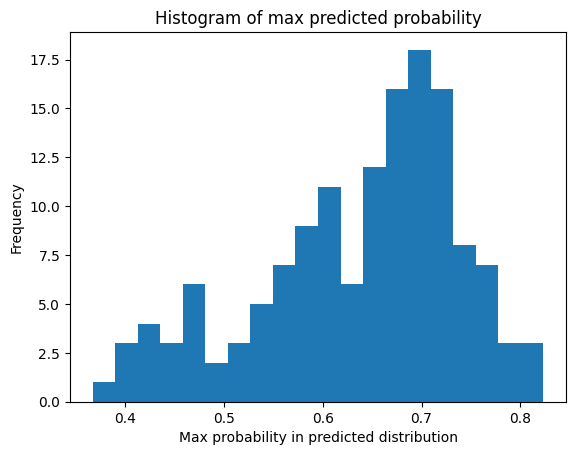

In [20]:
import matplotlib.pyplot as plt
plt.hist(max_probs, bins=20)
plt.title('Histogram of max predicted probability')
plt.xlabel('Max probability in predicted distribution')
plt.ylabel('Frequency')
plt.show()

In [21]:
# from here is the error analysis 



per_class_KL = np.array([
    entropy(y_true_test[:, i] + eps, y_pred_test[:, i] + eps)
    for i in range(y_true_test.shape[1])
])


top1_per_class = np.zeros(y_true_test.shape[1])
top3_per_class = np.zeros(y_true_test.shape[1])
cnt_per_class = np.zeros(y_true_test.shape[1])

for idx, (p, q) in enumerate(zip(y_true_test, y_pred_test)):
    gt_max = np.argmax(p)
    pred_rank = np.argsort(q)[::-1]
    cnt_per_class[gt_max] += 1
    if pred_rank[0] == gt_max:
        top1_per_class[gt_max] += 1
    if gt_max in pred_rank[:3]:
        top3_per_class[gt_max] += 1

top1_per_class_acc = np.divide(top1_per_class, cnt_per_class, out=np.zeros_like(top1_per_class), where=cnt_per_class!=0)
top3_per_class_acc = np.divide(top3_per_class, cnt_per_class, out=np.zeros_like(top3_per_class), where=cnt_per_class!=0)

print('\n===== Per-class KL/Top1/Top3 =====')
for i in np.argsort(-per_class_KL)[:21]:  
    print(f'{i:2d} | {soft_label_cols[i]:38} | KL={per_class_KL[i]:.3f} | Top1={top1_per_class_acc[i]:.3f} | Top3={top3_per_class_acc[i]:.3f} | Count={int(cnt_per_class[i])}')



===== Per-class KL/Top1/Top3 =====
10 | Home & Auto                            | KL=4.652 | Top1=0.000 | Top3=0.000 | Count=0
17 | Professional Services                  | KL=3.305 | Top1=0.000 | Top3=0.000 | Count=0
 0 | Auto Dealers                           | KL=3.211 | Top1=0.000 | Top3=0.000 | Count=1
15 | Non-Profits & Religious Organizations  | KL=2.829 | Top1=0.000 | Top3=0.000 | Count=1
14 | Local Events                           | KL=2.789 | Top1=0.000 | Top3=0.000 | Count=1
 3 | Creators & Celebrities                 | KL=2.702 | Top1=0.000 | Top3=0.400 | Count=5
 6 | General Interest                       | KL=2.693 | Top1=0.000 | Top3=0.000 | Count=2
 2 | Content & Apps                         | KL=2.680 | Top1=0.000 | Top3=0.000 | Count=2
 5 | Food & Personal Goods                  | KL=2.439 | Top1=0.000 | Top3=0.400 | Count=5
11 | Home Goods Stores                      | KL=2.438 | Top1=0.000 | Top3=0.000 | Count=2
13 | Lifestyle Services                     | KL=2.427

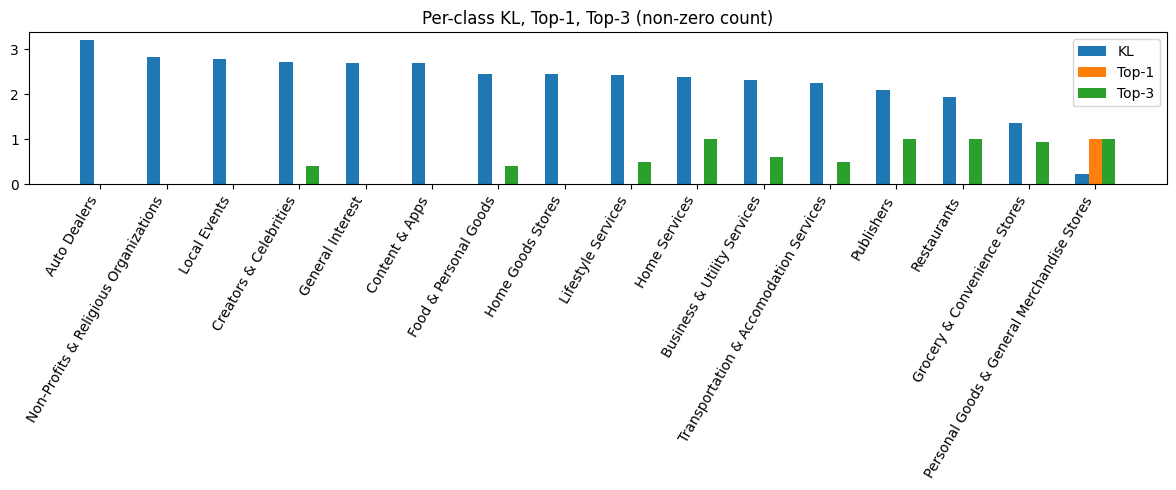

In [22]:
import matplotlib.pyplot as plt

labels = [soft_label_cols[i] for i in np.argsort(-per_class_KL) if cnt_per_class[i]>0]
kl_vals = [per_class_KL[i] for i in np.argsort(-per_class_KL) if cnt_per_class[i]>0]
top1_vals = [top1_per_class_acc[i] for i in np.argsort(-per_class_KL) if cnt_per_class[i]>0]
top3_vals = [top3_per_class_acc[i] for i in np.argsort(-per_class_KL) if cnt_per_class[i]>0]

x = np.arange(len(labels))
plt.figure(figsize=(12,5))
plt.bar(x-0.2, kl_vals, width=0.2, label='KL')
plt.bar(x, top1_vals, width=0.2, label='Top-1')
plt.bar(x+0.2, top3_vals, width=0.2, label='Top-3')
plt.xticks(x, labels, rotation=60, ha='right')
plt.legend()
plt.title('Per-class KL, Top-1, Top-3 (non-zero count)')
plt.tight_layout()
plt.show()


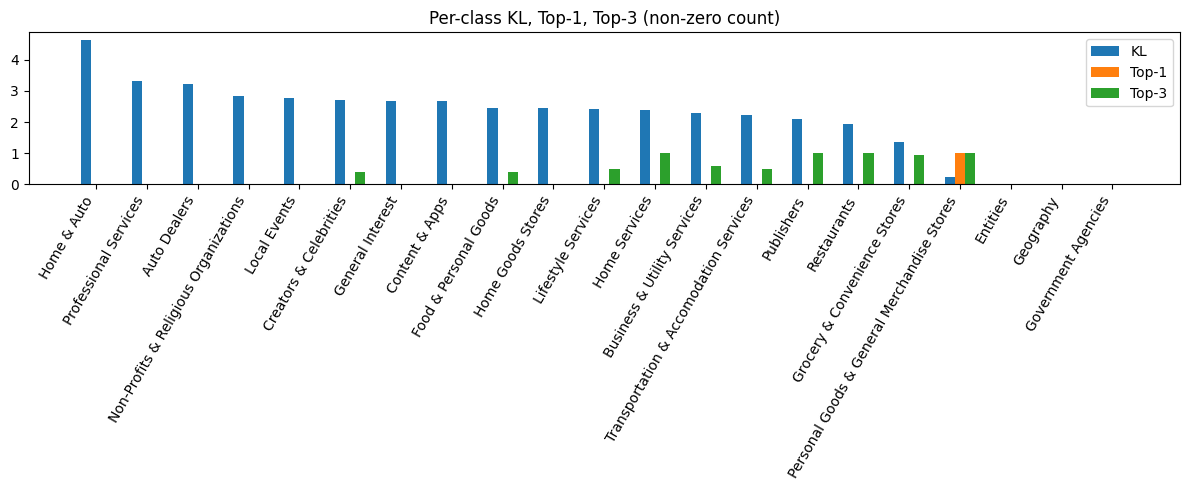

In [23]:
import matplotlib.pyplot as plt

labels = [soft_label_cols[i] for i in np.argsort(-per_class_KL) ]
kl_vals = [per_class_KL[i] for i in np.argsort(-per_class_KL) ]
top1_vals = [top1_per_class_acc[i] for i in np.argsort(-per_class_KL) ]
top3_vals = [top3_per_class_acc[i] for i in np.argsort(-per_class_KL)]

x = np.arange(len(labels))
plt.figure(figsize=(12,5))
plt.bar(x-0.2, kl_vals, width=0.2, label='KL')
plt.bar(x, top1_vals, width=0.2, label='Top-1')
plt.bar(x+0.2, top3_vals, width=0.2, label='Top-3')
plt.xticks(x, labels, rotation=60, ha='right')
plt.legend()
plt.title('Per-class KL, Top-1, Top-3 (non-zero count)')
plt.tight_layout()
plt.show()

In [25]:
#sample check 

kl_per_sample = np.array(KLs)
hard_idx = np.argsort(-kl_per_sample)[:5]  # KL最高的5个样本
easy_idx = np.argsort(kl_per_sample)[:5]   # KL最低的5个样本

print('hardest:')
for idx in hard_idx:
    print(f'Idx {idx}, KL={kl_per_sample[idx]:.3f}, True={np.argmax(y_true_test[idx])}, Pred={np.argmax(y_pred_test[idx])}')

print('easiest:')
for idx in easy_idx:
    print(f'Idx {idx}, KL={kl_per_sample[idx]:.3f}, True={np.argmax(y_true_test[idx])}, Pred={np.argmax(y_pred_test[idx])}')

hardest:
Idx 79, KL=3.045, True=6, Pred=16
Idx 65, KL=3.045, True=15, Pred=16
Idx 25, KL=3.045, True=13, Pred=16
Idx 132, KL=3.006, True=20, Pred=16
Idx 42, KL=2.990, True=1, Pred=16
easiest:
Idx 128, KL=0.194, True=16, Pred=16
Idx 90, KL=0.209, True=16, Pred=16
Idx 20, KL=0.218, True=16, Pred=16
Idx 135, KL=0.224, True=16, Pred=16
Idx 6, KL=0.226, True=16, Pred=16


In [26]:
for idx in hard_idx:
    print(f'Idx {idx}, KL={kl_per_sample[idx]:.3f}')
    print('  True:', np.round(y_true_test[idx], 3))
    print('  Pred:', np.round(y_pred_test[idx], 3))

Idx 79, KL=3.045
  True: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Pred: [0.032 0.01  0.016 0.007 0.005 0.011 0.048 0.005 0.005 0.134 0.005 0.029
 0.008 0.064 0.008 0.005 0.57  0.008 0.016 0.006 0.013]
Idx 65, KL=3.045
  True: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  Pred: [0.005 0.011 0.015 0.05  0.005 0.038 0.005 0.005 0.005 0.117 0.005 0.026
 0.02  0.019 0.008 0.048 0.53  0.008 0.011 0.007 0.063]
Idx 25, KL=3.045
  True: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  Pred: [0.005 0.026 0.005 0.005 0.005 0.008 0.005 0.005 0.005 0.054 0.005 0.005
 0.017 0.048 0.008 0.005 0.687 0.026 0.018 0.009 0.051]
Idx 132, KL=3.006
  True: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  Pred: [0.005 0.009 0.006 0.048 0.005 0.012 0.005 0.005 0.005 0.01  0.005 0.007
 0.061 0.007 0.006 0.006 0.711 0.026 0.007 0.01  0.049]
Idx 42, KL=2.990
  True: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 

In [27]:
for idx in easy_idx:
    print(f'Idx {idx}, KL={kl_per_sample[idx]:.3f}')
    print('  True:', np.round(y_true_test[idx], 3))
    print('  Pred:', np.round(y_pred_test[idx], 3))

Idx 128, KL=0.194
  True: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  Pred: [0.005 0.009 0.008 0.008 0.005 0.015 0.005 0.005 0.005 0.014 0.005 0.009
 0.006 0.007 0.008 0.006 0.823 0.026 0.012 0.016 0.007]
Idx 90, KL=0.209
  True: [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.024 0.    0.    0.    0.951 0.    0.    0.024 0.   ]
  Pred: [0.005 0.009 0.008 0.005 0.005 0.012 0.005 0.005 0.005 0.043 0.005 0.007
 0.054 0.007 0.008 0.006 0.766 0.026 0.007 0.01  0.007]
Idx 20, KL=0.218
  True: [0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.02 0.   0.02 0.04 0.04
 0.   0.   0.78 0.   0.02 0.02 0.04]
  Pred: [0.005 0.012 0.007 0.056 0.005 0.019 0.005 0.005 0.005 0.048 0.005 0.013
 0.059 0.009 0.009 0.006 0.659 0.026 0.019 0.016 0.014]
Idx 135, KL=0.224
  True: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  Pred: [0.005 0.01  0.009 0.011 0.005 0.018 0.005 0.005 0.005 0.02  0.005 0.007
 0.01  0.007 0.011 0.006 0.8   0.026 0.01 

In [ ]:
#from here is CNN 

In [28]:

import numpy as np
import pandas as pd


owners = np.load('cnn_test_owners.npy')
probs = np.load('cnn_test_probs.npy')    # shape [n_user, 21]

df = pd.DataFrame(probs, columns=soft_label_cols )
df.insert(0, 'owner', owners)

y_test_pred = df[soft_label_cols]


In [31]:

y_test_user = np.array(y_test_user, dtype=float)
y_test_pred = np.array(y_test_pred, dtype=float)


KLs, JSs, EMDs, COSs, PRs, SRs = [], [], [], [], [], []
top1_correct, top3_correct = 0, 0

for p, q in zip(y_test_user, y_test_pred):
    KL = entropy(p, q)
    if np.isnan(KL): KL = 0
    KLs.append(KL)
    m = 0.5 * (p + q)
    js = 0.5 * entropy(p, m) + 0.5 * entropy(q, m)
    if np.isnan(js): js = 0
    JSs.append(js)
    EMDs.append(wasserstein_distance(bins, bins, p, q))
    COSs.append(1 - pairwise_distances(p[np.newaxis], q[np.newaxis], metric='cosine')[0, 0])
    pr = pearsonr(p, q)[0]
    sr = spearmanr(p, q).correlation
    if np.isnan(pr): pr = 0
    if np.isnan(sr): sr = 0
    PRs.append(pr)
    SRs.append(sr)
    gt_max = np.argmax(p)
    pred_rank = np.argsort(q)[::-1]
    if pred_rank[0] == gt_max:
        top1_correct += 1
    if gt_max in pred_rank[:3]:
        top3_correct += 1

n = len(y_true_val)
metrics = {
    'KL(mean)'          : np.mean(KLs),
    'JS(mean)'          : np.mean(JSs),
    'EMD(mean)'         : np.mean(EMDs),
    'Cosine(mean)'      : np.mean(COSs),
    'Pearson_r'         : np.mean(PRs),
    'Spearman_r'        : np.mean(SRs),
    'Top-1 Acc'         : top1_correct / n,
    'Top-3 Acc'         : top3_correct / n,
    'Per-class KL(mean)': np.mean([
    entropy(y_test_user[:, i] + eps, y_test_pred[:, i] + eps)
    for i in range(y_test_user.shape[1])])
}


for k, v in metrics.items():
    print(f'{k:<18}: {v:.4f}')

KL(mean)          : 1.1444
JS(mean)          : 0.2262
EMD(mean)         : 3.0273
Cosine(mean)      : 0.7553
Pearson_r         : 0.7333
Spearman_r        : 0.3712
Top-1 Acc         : 0.7164
Top-3 Acc         : 0.8806
Per-class KL(mean): 2.6653


In [30]:
# run on test 

alpha = 0.95
num_classes = y_test_pred.shape[1]
y_pred_smooth = alpha * y_test_pred + (1 - alpha) / num_classes

eps = 1e-12
y_pred_smooth = np.clip(y_pred_smooth, eps, None)
y_pred_smooth = y_pred_smooth / y_pred_smooth.sum(axis=1, keepdims=True)

y_test_user = np.array(y_test_user, dtype=float) + eps
y_test_user = y_test_user / y_test_user.sum(axis=1, keepdims=True)

bins = np.arange(y_test_user.shape[1])

KLs, JSs, EMDs, COSs, PRs, SRs = [], [], [], [], [], []
top1_correct, top3_correct = 0, 0

for p, q in zip(y_test_user, y_pred_smooth):    # 用y_pred_smooth!
    KL = entropy(p, q)
    if np.isnan(KL): KL = 0
    KLs.append(KL)
    m = 0.5 * (p + q)
    js = 0.5 * entropy(p, m) + 0.5 * entropy(q, m)
    if np.isnan(js): js = 0
    JSs.append(js)
    EMDs.append(wasserstein_distance(bins, bins, p, q))
    COSs.append(1 - pairwise_distances(p[np.newaxis], q[np.newaxis], metric='cosine')[0, 0])
    pr = pearsonr(p, q)[0]
    sr = spearmanr(p, q).correlation
    if np.isnan(pr): pr = 0
    if np.isnan(sr): sr = 0
    PRs.append(pr)
    SRs.append(sr)
    gt_max = np.argmax(p)
    pred_rank = np.argsort(q)[::-1]
    if pred_rank[0] == gt_max:
        top1_correct += 1
    if gt_max in pred_rank[:3]:
        top3_correct += 1

n = len(y_test_user)
metrics = {
    'KL(mean)'          : np.mean(KLs),
    'JS(mean)'          : np.mean(JSs),
    'EMD(mean)'         : np.mean(EMDs),
    'Cosine(mean)'      : np.mean(COSs),
    'Pearson_r'         : np.mean(PRs),
    'Spearman_r'        : np.mean(SRs),
    'Top-1 Acc'         : top1_correct / n,
    'Top-3 Acc'         : top3_correct / n,
    'Per-class KL(mean)': np.mean([
        entropy(y_test_user[:, i] + eps, y_pred_smooth[:, i] + eps)
        for i in range(y_test_user.shape[1])])
}

for k, v in metrics.items():
    print(f'{k:<18}: {v:.4f}')
#this kind of smoothing let the result becmoe worse, not better. have tried a lot alpha

KL(mean)          : 1.1356
JS(mean)          : 0.2349
EMD(mean)         : 3.1288
Cosine(mean)      : 0.7556
Pearson_r         : 0.7333
Spearman_r        : 0.3712
Top-1 Acc         : 0.6713
Top-3 Acc         : 0.8252
Per-class KL(mean): 2.6449


In [32]:
y_true_cnn_test=y_test_user
y_pred_cnn_test=y_test_pred

In [36]:
max_probs = y_pred_cnn_test.max(axis=1)
print(max_probs.mean().round(3))
print(max_probs.max().round(3))
print(max_probs.min().round(3))

0.664
0.899
0.279


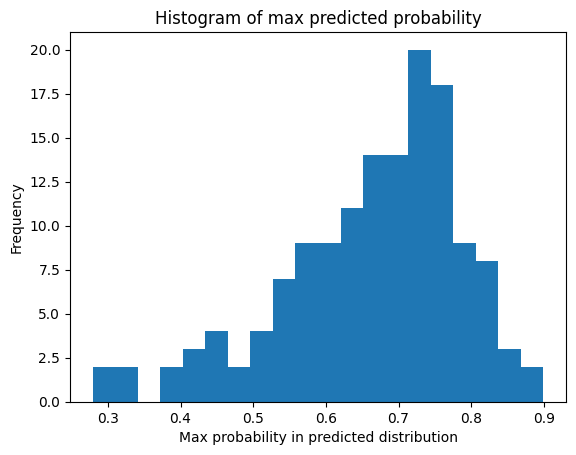

In [37]:
import matplotlib.pyplot as plt
plt.hist(max_probs, bins=20)
plt.title('Histogram of max predicted probability')
plt.xlabel('Max probability in predicted distribution')
plt.ylabel('Frequency')
plt.show()

In [42]:
eps = 1e-12
per_class_KL = np.array([
    entropy(y_true_cnn_test[:, i] + eps, y_pred_cnn_test[:, i] + eps)
    for i in range(y_true_cnn_test.shape[1])
])

top1_per_class = np.zeros(y_true_cnn_test.shape[1])
top3_per_class = np.zeros(y_true_cnn_test.shape[1])
cnt_per_class = np.zeros(y_true_cnn_test.shape[1])

for idx, (p, q) in enumerate(zip(y_true_cnn_test, y_pred_cnn_test)):
    gt_max = np.argmax(p)
    pred_rank = np.argsort(q)[::-1]
    cnt_per_class[gt_max] += 1
    if pred_rank[0] == gt_max:
        top1_per_class[gt_max] += 1
    if gt_max in pred_rank[:3]:
        top3_per_class[gt_max] += 1

top1_per_class_acc = np.divide(top1_per_class, cnt_per_class, out=np.zeros_like(top1_per_class), where=cnt_per_class!=0)
top3_per_class_acc = np.divide(top3_per_class, cnt_per_class, out=np.zeros_like(top3_per_class), where=cnt_per_class!=0)

print('\n===== Per-class KL/Top1/Top3 =====')
for i in np.argsort(-per_class_KL)[:5]:  
    print(f'{i:2d} | {soft_label_cols[i]:38} | KL={per_class_KL[i]:.3f} | Top1={top1_per_class_acc[i]:.3f} | Top3={top3_per_class_acc[i]:.3f} | Count={int(cnt_per_class[i])}')


===== Per-class KL/Top1/Top3 =====
10 | Home & Auto                            | KL=4.872 | Top1=0.000 | Top3=0.000 | Count=0
 3 | Creators & Celebrities                 | KL=4.172 | Top1=0.000 | Top3=0.000 | Count=5
17 | Professional Services                  | KL=4.086 | Top1=0.000 | Top3=0.000 | Count=0
 0 | Auto Dealers                           | KL=4.082 | Top1=0.000 | Top3=0.000 | Count=1
15 | Non-Profits & Religious Organizations  | KL=3.996 | Top1=0.000 | Top3=0.000 | Count=1


In [43]:
print('\n===== Per-class KL/Top1/Top3(non-zero) =====')
for i in np.argsort(-per_class_KL):
   
        print(f'{i:2d} | {soft_label_cols[i]:38} | KL={per_class_KL[i]:.3f} | Top1={top1_per_class_acc[i]:.3f} | Top3={top3_per_class_acc[i]:.3f} | Count={int(cnt_per_class[i])}')



===== Per-class KL/Top1/Top3(non-zero) =====
10 | Home & Auto                            | KL=4.872 | Top1=0.000 | Top3=0.000 | Count=0
 3 | Creators & Celebrities                 | KL=4.172 | Top1=0.000 | Top3=0.000 | Count=5
17 | Professional Services                  | KL=4.086 | Top1=0.000 | Top3=0.000 | Count=0
 0 | Auto Dealers                           | KL=4.082 | Top1=0.000 | Top3=0.000 | Count=1
15 | Non-Profits & Religious Organizations  | KL=3.996 | Top1=0.000 | Top3=0.000 | Count=1
14 | Local Events                           | KL=3.809 | Top1=0.000 | Top3=0.000 | Count=1
 6 | General Interest                       | KL=3.574 | Top1=0.000 | Top3=0.000 | Count=2
18 | Publishers                             | KL=3.356 | Top1=0.000 | Top3=0.000 | Count=1
 1 | Business & Utility Services            | KL=2.953 | Top1=0.000 | Top3=0.000 | Count=5
 2 | Content & Apps                         | KL=2.914 | Top1=0.000 | Top3=0.000 | Count=2
13 | Lifestyle Services                     

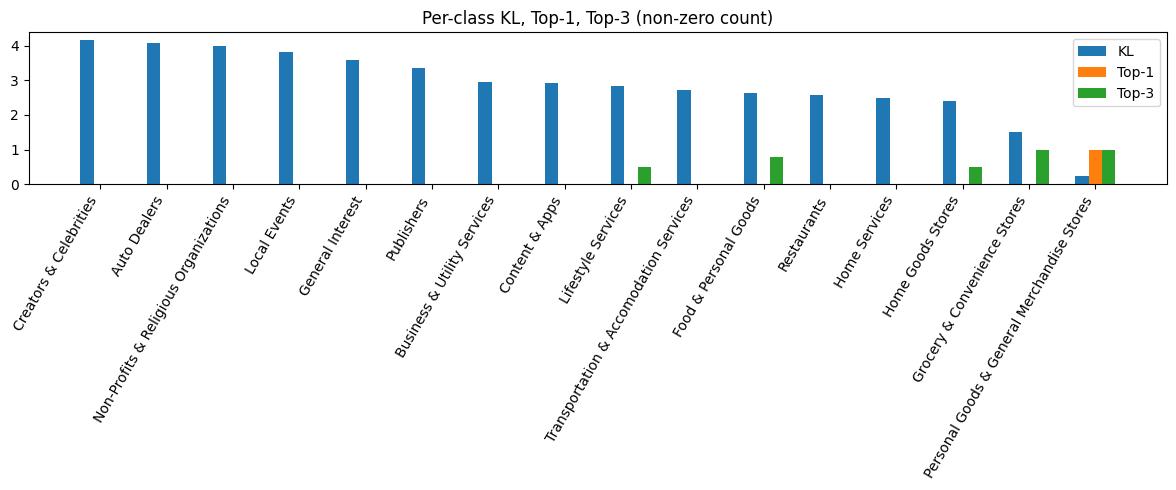

In [46]:
import matplotlib.pyplot as plt

labels = [soft_label_cols[i] for i in np.argsort(-per_class_KL) if cnt_per_class[i]>0]
kl_vals = [per_class_KL[i] for i in np.argsort(-per_class_KL) if cnt_per_class[i]>0]
top1_vals = [top1_per_class_acc[i] for i in np.argsort(-per_class_KL) if cnt_per_class[i]>0]
top3_vals = [top3_per_class_acc[i] for i in np.argsort(-per_class_KL) if cnt_per_class[i]>0]

x = np.arange(len(labels))
plt.figure(figsize=(12,5))
plt.bar(x-0.2, kl_vals, width=0.2, label='KL')
plt.bar(x, top1_vals, width=0.2, label='Top-1')
plt.bar(x+0.2, top3_vals, width=0.2, label='Top-3')
plt.xticks(x, labels, rotation=60, ha='right')
plt.legend()
plt.title('Per-class KL, Top-1, Top-3 (non-zero count)')
plt.tight_layout()
plt.show()

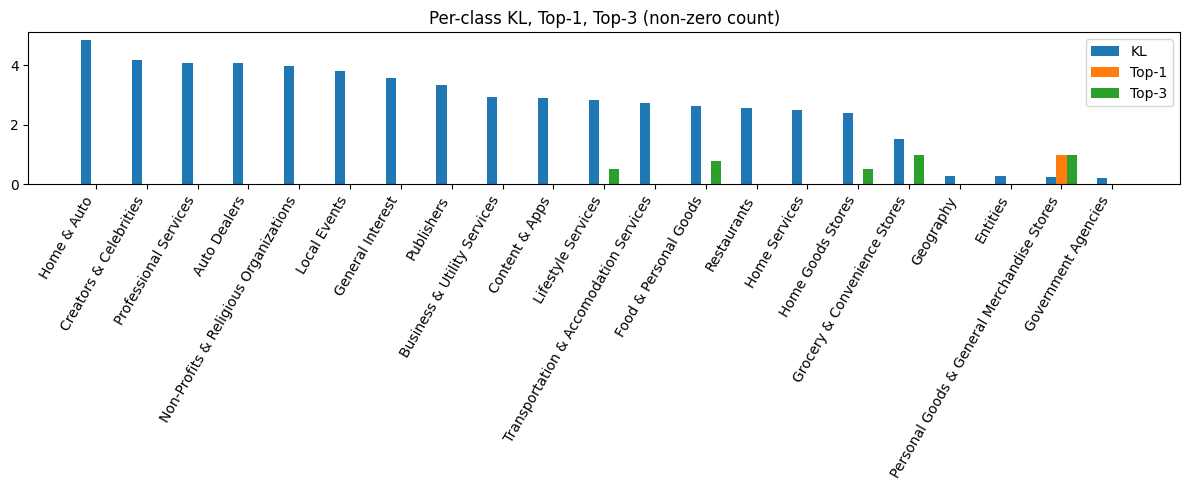

In [47]:
import matplotlib.pyplot as plt

labels = [soft_label_cols[i] for i in np.argsort(-per_class_KL)]
kl_vals = [per_class_KL[i] for i in np.argsort(-per_class_KL) ]
top1_vals = [top1_per_class_acc[i] for i in np.argsort(-per_class_KL) ]
top3_vals = [top3_per_class_acc[i] for i in np.argsort(-per_class_KL) ]

x = np.arange(len(labels))
plt.figure(figsize=(12,5))
plt.bar(x-0.2, kl_vals, width=0.2, label='KL')
plt.bar(x, top1_vals, width=0.2, label='Top-1')
plt.bar(x+0.2, top3_vals, width=0.2, label='Top-3')
plt.xticks(x, labels, rotation=60, ha='right')
plt.legend()
plt.title('Per-class KL, Top-1, Top-3 (non-zero count)')
plt.tight_layout()
plt.show()

In [51]:
KLs = [entropy(p+eps, q+eps) for p, q in zip(y_true_cnn_test, y_pred_cnn_test)]
kl_per_sample = np.array(KLs)
hard_idx = np.argsort(-kl_per_sample)[:5]  # KL最高的5个样本
easy_idx = np.argsort(kl_per_sample)[:5]   # KL最低的5个样本

print('hardest:')
for idx in hard_idx:
    print(f'Idx {idx}, KL={kl_per_sample[idx]:.3f}, True={np.argmax(y_true_cnn_test[idx])}, Pred={np.argmax(y_pred_cnn_test[idx])}')

print('easiest:')
for idx in easy_idx:
    print(f'Idx {idx}, KL={kl_per_sample[idx]:.3f}, True={np.argmax(y_true_cnn_test[idx])}, Pred={np.argmax(y_pred_cnn_test[idx])}')

hardest:
Idx 65, KL=6.039, True=15, Pred=16
Idx 79, KL=5.769, True=6, Pred=16
Idx 140, KL=5.216, True=3, Pred=16
Idx 68, KL=5.095, True=6, Pred=16
Idx 77, KL=4.960, True=3, Pred=16
easiest:
Idx 2, KL=0.106, True=16, Pred=16
Idx 92, KL=0.152, True=16, Pred=16
Idx 20, KL=0.152, True=16, Pred=16
Idx 114, KL=0.161, True=16, Pred=16
Idx 50, KL=0.164, True=16, Pred=16


In [52]:
for idx in hard_idx:
    print(f'Idx {idx}, KL={kl_per_sample[idx]:.3f}')
    print('  True:', np.round(y_true_cnn_test[idx], 3))
    print('  Pred:', np.round(y_pred_cnn_test[idx], 3))

Idx 65, KL=6.039
  True: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  Pred: [0.006 0.012 0.007 0.014 0.    0.105 0.002 0.    0.002 0.054 0.001 0.01
 0.035 0.013 0.036 0.002 0.625 0.005 0.025 0.015 0.029]
Idx 79, KL=5.769
  True: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Pred: [0.007 0.021 0.009 0.131 0.    0.046 0.003 0.001 0.002 0.088 0.002 0.014
 0.031 0.016 0.017 0.003 0.526 0.008 0.034 0.017 0.023]
Idx 140, KL=5.216
  True: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Pred: [0.006 0.011 0.012 0.005 0.    0.068 0.002 0.001 0.003 0.079 0.002 0.017
 0.045 0.014 0.073 0.003 0.571 0.007 0.018 0.016 0.048]
Idx 68, KL=5.095
  True: [0.    0.    0.    0.    0.    0.    0.667 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.333 0.    0.    0.   ]
  Pred: [0.005 0.025 0.009 0.016 0.    0.039 0.002 0.    0.003 0.095 0.001 0.051
 0.053 0.02  0.011 0.002 0.59  0.01  0.029 0.021 0.017]
Idx 77, KL=4.960
  True: [0. 0.

In [53]:
for idx in easy_idx:
    print(f'Idx {idx}, KL={kl_per_sample[idx]:.3f}')
    print('  True:', np.round(y_true_cnn_test[idx], 3))
    print('  Pred:', np.round(y_pred_cnn_test[idx], 3))

Idx 2, KL=0.106
  True: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  Pred: [0.001 0.002 0.002 0.001 0.    0.012 0.    0.    0.    0.014 0.    0.004
 0.009 0.038 0.003 0.    0.899 0.001 0.006 0.004 0.003]
Idx 92, KL=0.152
  True: [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.062 0.    0.
 0.    0.    0.    0.    0.937 0.    0.    0.    0.   ]
  Pred: [0.002 0.009 0.009 0.009 0.    0.026 0.001 0.    0.001 0.059 0.    0.016
 0.015 0.01  0.007 0.001 0.801 0.004 0.006 0.013 0.011]
Idx 20, KL=0.152
  True: [0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.02 0.   0.02 0.04 0.04
 0.   0.   0.78 0.   0.02 0.02 0.04]
  Pred: [0.004 0.018 0.008 0.021 0.    0.04  0.001 0.    0.002 0.077 0.001 0.028
 0.031 0.013 0.009 0.002 0.684 0.008 0.018 0.019 0.016]
Idx 114, KL=0.161
  True: [0.    0.    0.    0.    0.    0.083 0.    0.    0.    0.083 0.    0.
 0.    0.    0.    0.    0.833 0.    0.    0.    0.   ]
  Pred: [0.002 0.009 0.003 0.026 0.    0.03  0.001 0.    0.001 0